In [3]:
import pandas as pd
import numpy as np

In [ ]:
# 데이터 읽기
EASE_check_10output = pd.read_csv('EASE_check_10output.csv')
EASE_check_30output = pd.read_csv('EASE_check_30output.csv')

answer = pd.read_csv('EASE_check_answer.csv')

from collections import Counter
from tqdm import tqdm

# 유저별 시청한 영화 장르 파악
gen = pd.read_csv("/opt/ml/input/data/train/genres.tsv", delimiter='\t')
raw_data = pd.read_csv('/opt/ml/input/data/train/train_ratings.csv')
users = raw_data.user.unique()
user_genre = pd.DataFrame([users]).T
user_genre.columns = ['users']

# 유저별 장르 선호에 따른 추천
for x in gen.genre.unique():
    user_genre[x] = 0
user_genre.set_index('users', inplace=True)


users = raw_data.user.unique()

for i in tqdm(range(len(users))):
    user_item = raw_data[raw_data.user == users[i]].item.values
    user_fav_genre = []
    for x in user_item:
        user_fav_genre.extend(gen[gen.item == x].genre.values)

    counter_user = Counter(user_fav_genre).most_common()
    for x, y in counter_user:
        user_genre.loc[users[i], x] = y

# EASE_check_10output

In [5]:
# 유저별 recall 값 구하기
from tqdm import tqdm

recall_per_user = []
index_user = sorted(EASE_check_10output.user.value_counts().index.values)
for x in tqdm(index_user):
    item_list = EASE_check_10output[EASE_check_10output.user == x].item.values
    cnt = 0
    for ele in item_list:
        if ele in answer[answer.user == x].item.values:
            cnt += 1
    recall_per_user.append(cnt / np.minimum(10, len(answer[answer.user == x])))

100%|██████████| 31360/31360 [05:47<00:00, 90.12it/s]


In [6]:
all_result = pd.DataFrame([index_user, recall_per_user]).T
all_result.columns = ['user', 'recall@10']
all_result

,user,recall@10
0,11.0,0.9
1,14.0,0.7
2,18.0,0.2
3,25.0,0.3
4,31.0,0.8
...,...,...
31355,138473.0,0.2
31356,138475.0,0.6
31357,138486.0,0.6
31358,138492.0,0.3


In [8]:
np.mean(recall_per_user)

0.5112092545351474

In [7]:
len(recall_per_user)

31360

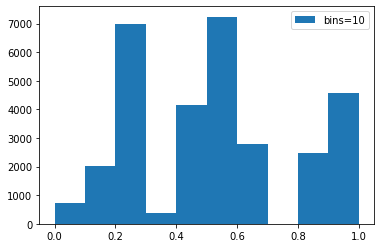

In [9]:
# 분포 보기
import matplotlib.pyplot as plt

plt.hist(recall_per_user, label='bins=10')
#plt.hist(recall_per_user, bins=30, label='bins=30')
plt.legend()
plt.show()

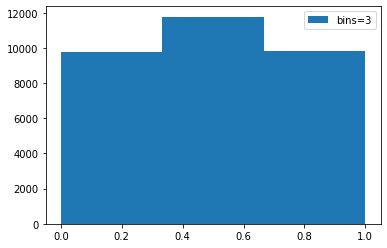

In [10]:
# 못 맞춘 그룹(A), 중간 그룹(B), 잘 맞춘 그룹(C):
plt.hist(recall_per_user, bins=3, label='bins=3')
plt.legend()
plt.show()

In [11]:
low_result = all_result[all_result['recall@10'] < 0.3]
mid_result = all_result[(all_result['recall@10'] >= 0.3) & (all_result['recall@10'] < 0.7)]
good_result = all_result[(all_result['recall@10'] >= 0.7) & (all_result['recall@10'] <= 1)]

print(len(low_result))
print(len(mid_result))
print(len(good_result))

6031
15508
9821


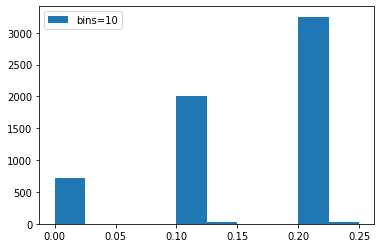

In [12]:
import matplotlib.pyplot as plt

plt.hist(low_result['recall@10'], label='bins=10')
#plt.hist(recall_per_user, bins=30, label='bins=30')
plt.legend()
plt.show()

In [14]:
# 0.15 이하 찾아보기
lowest_result = low_result[low_result['recall@10'] <= 0.15]
lowest_result.user = lowest_result.user.astype('int')
lowest_result_users = lowest_result.user.values
lowest_reco_result = EASE_check_10output[EASE_check_10output.user.isin(lowest_result_users)]
lowest_result_users
len(lowest_result_users)

/tmp/ipykernel_31698/230265913.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lowest_result.user = lowest_result.user.astype('int')


2757

In [ ]:
#lr = pd.DataFrame(lowest_reco_result.user.unique(), columns=['lowest_user'])
#lr.to_csv('ease_lowest_user.csv')

In [15]:
good_result.user = good_result.user.astype('int')
best_result_users = good_result.user.values
best_reco_result = EASE_check_10output[EASE_check_10output.user.isin(best_result_users)]
best_reco_result

/tmp/ipykernel_31698/1279577262.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_result.user = good_result.user.astype('int')


,user,item
0,11,1917
1,11,4226
2,11,4896
3,11,5952
4,11,6502
...,...,...
313595,138493,8360
313596,138493,551
313597,138493,2628
313598,138493,356


In [16]:
best_result_users

array([    11,     14,     31, ..., 138437, 138472, 138493])

In [17]:
best_reco_result.user.nunique()

9821

In [18]:
lowest_result_users

array([    43,     72,    102, ..., 138259, 138305, 138397])

In [19]:
raw_data = pd.read_csv('/opt/ml/input/data/train/train_ratings.csv')

good_result.user = good_result.user.astype('int')
best_result_users = good_result.user.values
best_reco_result = EASE_check_10output[EASE_check_10output.user.isin(best_result_users)]

lowest_history = raw_data[raw_data.user.isin(lowest_result_users)]
lowest_x = lowest_history.groupby('user').size().values

best_history = raw_data[raw_data.user.isin(best_result_users)]
best_x= best_history.groupby('user').size().values

ori_grouped = raw_data.groupby('user')
ori_x = ori_grouped.size().values

/tmp/ipykernel_31698/234098951.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_result.user = good_result.user.astype('int')


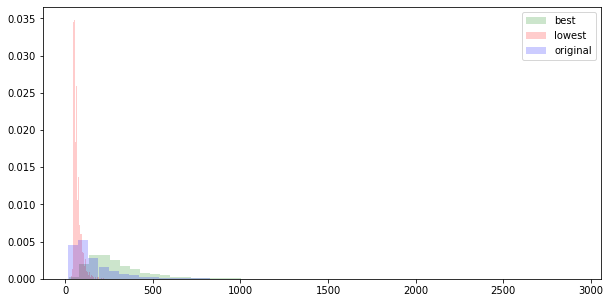

In [20]:
#density 변수를 True로 설정하면, 각 구간의 개수가 y축에서 표현되는 것이 아니라, 각 구간의 빈도가 표시되는 것으로 변경.
plt.figure(figsize = (10, 5))
plt.hist(best_x, color = 'green', alpha = 0.2, bins = 50, label = 'best', density = True)
plt.hist(lowest_x, color = 'red', alpha = 0.2, bins = 50, label = 'lowest', density = True)
plt.hist(ori_x, color = 'blue', alpha = 0.2, bins = 50, label = 'original', density = True)
plt.legend()
plt.show()

### => 대체로 시청 이력이 적은 사람들이 추천이 잘 안된다.

/opt/conda/envs/panda_down/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


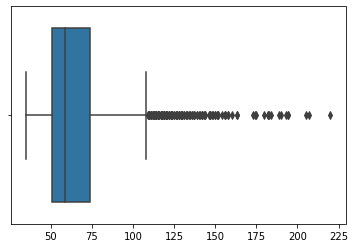

In [21]:
import seaborn as sns

sns.boxplot(lowest_x)#x = "total_bill",  data = tips)
plt.show()

In [22]:
print(np.mean(best_x)) #평균적으로 90회 봄.
print(np.std(best_x))

303.6816006516648
193.89829593528154


In [23]:
print(np.mean(lowest_x)) #평균적으로 90회 봄.
print(np.std(lowest_x))

66.58215451577802
22.913429687981623


### 가설 1: 못 맞춘 유저들에게 시청이력이 많은 영화를 추천해준다.

#### 데이터셋 준비: worst

In [46]:
lowest_user_reco = pd.DataFrame(EASE_check_10output[EASE_check_10output['user'].isin(lowest_result_users)].item.value_counts())
lowest_user_reco.reset_index(inplace=True)
lowest_user_reco.columns=['item', 'reco_count']
lowest_user_reco

,item,reco_count
0,2571,444
1,296,420
2,318,419
3,2959,400
4,2858,390
...,...,...
1154,3328,1
1155,8019,1
1156,4326,1
1157,3198,1


In [47]:
lowest_reco = EASE_check_10output[EASE_check_10output['user'].isin(lowest_result_users)]
lowest_reco['view'] = 0

In [26]:
lowest_reco.reset_index(drop=True, inplace=True)
lowest_reco

,user,item,view
0,43,4886,0
1,43,17,0
2,43,1197,0
3,43,4973,0
4,43,110,0
...,...,...,...
27565,138397,1371,0
27566,138397,173,0
27567,138397,3697,0
27568,138397,8371,0


In [27]:
def count_views(x):
    return len(raw_data[raw_data.item == x])

lowest_reco.view = lowest_reco['item'].apply(lambda x: count_views(x))

/tmp/ipykernel_31698/95028635.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lowest_reco.view = lowest_reco['item'].apply(lambda x: count_views(x))


In [28]:
lowest_history = raw_data[raw_data.user.isin(lowest_result_users)]#.user.value_counts())
lowest_history['view'] = 0
lowest_history

/tmp/ipykernel_31698/3142832355.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lowest_history['view'] = 0


,user,item,time,view
1050,43,261,1231445317,0
1051,43,3082,1231445359,0
1052,43,1962,1231445370,0
1053,43,2881,1231445381,0
1054,43,531,1231445386,0
...,...,...,...,...
5149686,138397,1616,1117048310,0
5149687,138397,5611,1117048312,0
5149688,138397,7379,1117048319,0
5149689,138397,5420,1117048324,0


In [29]:
def count_views(x):
    return len(raw_data[raw_data.item == x])

lowest_history.view = lowest_history['item'].apply(lambda x: count_views(x))

/tmp/ipykernel_31698/3982728275.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lowest_history.view = lowest_history['item'].apply(lambda x: count_views(x))


In [30]:
#저장
lowest_history.to_csv('EASE_lowest_history.csv')
lowest_reco.to_csv('EASE_lowest_reco.csv')

In [48]:
lowest_history = pd.read_csv('EASE_lowest_history.csv', )
lowest_history.drop('Unnamed: 0', axis=1, inplace=True)
lowest_reco = pd.read_csv('EASE_lowest_reco.csv')
lowest_reco.drop('Unnamed: 0', axis=1, inplace=True)

In [32]:
lowest_history

,user,item,time,view
0,43,261,1231445317,1014
1,43,3082,1231445359,1314
2,43,1962,1231445370,1746
3,43,2881,1231445381,896
4,43,531,1231445386,966
...,...,...,...,...
183562,138397,1616,1117048310,291
183563,138397,5611,1117048312,132
183564,138397,7379,1117048319,106
183565,138397,5420,1117048324,249


In [33]:
lowest_reco

,user,item,view
0,43,4886,10826
1,43,17,2380
2,43,1197,9685
3,43,4973,11846
4,43,110,12359
...,...,...,...
27565,138397,1371,1122
27566,138397,173,691
27567,138397,3697,741
27568,138397,8371,1433


#### 데이터셋 준비: best

In [23]:
best_result_users

array([    31,    116,    133, ..., 138419, 138472, 138493])

In [34]:
#### 데이터셋 준비: worst
def count_views(x):
    return len(raw_data[raw_data.item == x])

best_user_reco = pd.DataFrame(EASE_check_10output[EASE_check_10output['user'].isin(best_result_users)].item.value_counts())
best_user_reco.reset_index(inplace=True)
best_user_reco.columns=['item', 'reco_count']
best_user_reco

,item,reco_count
0,2571,1238
1,2959,1111
2,296,1083
3,318,1068
4,5952,1057
...,...,...
1768,5791,1
1769,1279,1
1770,26082,1
1771,1092,1


In [38]:
tmp = pd.DataFrame(raw_data.item.value_counts())
tmp.reset_index(inplace=True, drop=False)
tmp.columns = ['item', 'view']

best_history = raw_data[raw_data.user.isin(best_result_users)]#.user.value_counts())
best_history = pd.merge(best_history, tmp, left_on='item', right_on='item', how='inner')
best_history


,user,item,time,view
0,11,4643,1230782529,1122
1,294,4643,1288437662,1122
2,609,4643,1131396199,1122
3,829,4643,1337644649,1122
4,951,4643,1170632154,1122
...,...,...,...,...
2982452,120172,2036,1266567880,62
2982453,120290,2036,1165171128,62
2982454,122674,2036,1307274746,62
2982455,128943,2036,1193334539,62


In [39]:
best_reco = EASE_check_10output[EASE_check_10output['user'].isin(best_result_users)]
best_reco.reset_index(drop=True, inplace=True)
best_reco = pd.merge(best_reco, tmp, left_on='item', right_on='item', how='inner')
best_reco

,user,item,view
0,11,1917,3919
1,11,4226,14726
2,11,4896,6431
3,11,5952,16387
4,11,6502,6365
...,...,...,...
98205,138493,8360,6898
98206,138493,551,5378
98207,138493,2628,4880
98208,138493,356,17339


In [40]:
#저장
best_history.to_csv('EASE_best_history.csv')
best_reco.to_csv('EASE_best_reco.csv')


In [49]:
best_history = pd.read_csv('EASE_best_history.csv', )
best_history.drop('Unnamed: 0', axis=1, inplace=True)
best_reco = pd.read_csv('EASE_best_reco.csv')
best_reco.drop('Unnamed: 0', axis=1, inplace=True)

In [50]:
raw_data = pd.read_csv('/opt/ml/input/data/train/train_ratings.csv')
raw_data

,user,item,time
0,11,4643,1230782529
1,11,170,1230782534
2,11,531,1230782539
3,11,616,1230782542
4,11,2140,1230782563
...,...,...,...
5154466,138493,44022,1260209449
5154467,138493,4958,1260209482
5154468,138493,68319,1260209720
5154469,138493,40819,1260209726


In [51]:
all_items = pd.DataFrame(raw_data.item.value_counts())
all_items.reset_index(inplace=True)
all_items.columns=['item', 'view']
all_items

,item,view
0,2571,19699
1,2959,18437
2,296,18202
3,318,18168
4,356,17339
...,...,...
6802,7259,38
6803,126,36
6804,4241,34
6805,2555,34


In [52]:
import warnings
warnings.filterwarnings(action='ignore') 

#### 가설1. 검증

In [ ]:
import scipy.stats
#귀무가설: 못 맞춘 유저들의 시청이력 평균은 영화들의 시청이력 평균보다 작다.
#대립가설: 못 맞춘 유저들의 시청이력 평균은 영화들의 시청이력 평균보다 크거나 같다.
user_idx = 18
scipy.stats.ttest_ind(all_items.view.values,
        lowest_reco[lowest_reco.user==user_idx].view.values,
        alternative='greater')
#검증 결과, 두 집단의 평균 차이는 통계적으로 유의미함 (p<0.05) -> 귀무가설 채택

In [53]:
lowest_users = lowest_reco.user.unique()
lowest_users

array([    43,     72,    102, ..., 138259, 138305, 138397])

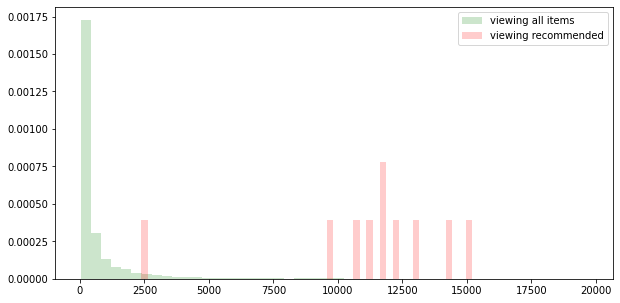

영화들의 시청이력 평균: 757.231
영화들의 시청이력 표준 편차: 1682.849
추천된 영화들의 시청이력 평균: 11265.4
추천된 영화들의 시청이력 표준 편차: 3342.542


In [55]:
# worst 그룹: 전체 영화랑 추천된 영화에 대해 시청한 유저수(시청이력수) 비교.
import matplotlib.pyplot as plt

user_idx = lowest_users[0]

plt.figure(figsize = (10, 5))
plt.hist(all_items.view.values, color = 'green', alpha = 0.2, bins = 50, label = 'viewing all items', density = True)
plt.hist(lowest_reco[lowest_reco.user==user_idx].view.values, color = 'red', alpha = 0.2, bins = 50, label = 'viewing recommended', density = True)
plt.legend()
plt.show()

print('영화들의 시청이력 평균:', round(np.mean(all_items.view.values), 3))
print('영화들의 시청이력 표준 편차:', round(np.std(all_items.view.values), 3))

print('추천된 영화들의 시청이력 평균:', round(np.mean(lowest_reco[lowest_reco.user==user_idx].view.values), 3))
print('추천된 영화들의 시청이력 표준 편차:', round(np.std(lowest_reco[lowest_reco.user==user_idx].view.values), 3))


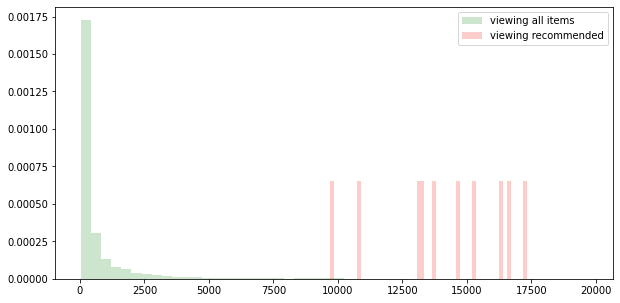

영화들의 시청이력 평균: 757.231
영화들의 시청이력 표준 편차: 1682.849
추천된 영화들의 시청이력 평균: 14089.8
추천된 영화들의 시청이력 표준 편차: 2356.918


In [56]:
# worst 그룹: 전체 영화랑 추천된 영화에 대해 시청한 유저수(시청이력수) 비교.
import matplotlib.pyplot as plt

user_idx = lowest_users[2]

plt.figure(figsize = (10, 5))
plt.hist(all_items.view.values, color = 'green', alpha = 0.2, bins = 50, label = 'viewing all items', density = True)
plt.hist(lowest_reco[lowest_reco.user==user_idx].view.values, color = 'red', alpha = 0.2, bins = 50, label = 'viewing recommended', density = True)
plt.legend()
plt.show()

print('영화들의 시청이력 평균:', round(np.mean(all_items.view.values), 3))
print('영화들의 시청이력 표준 편차:', round(np.std(all_items.view.values), 3))

print('추천된 영화들의 시청이력 평균:', round(np.mean(lowest_reco[lowest_reco.user==user_idx].view.values), 3))
print('추천된 영화들의 시청이력 표준 편차:', round(np.std(lowest_reco[lowest_reco.user==user_idx].view.values), 3))


In [57]:
from tqdm import tqdm

mean_all = np.mean(all_items.view.values)
std_all = np.std(all_items.view.values)

cnt = 0
for i in tqdm(range(len(lowest_users))):
    idx = lowest_users[i]
    if mean_all + std_all < np.mean(lowest_reco[lowest_reco.user==idx].view.values):
        cnt += 1

print('worst 그룹에 추천된 영화들이 기존 영화들의 시청횟수보다 클 확률: ', cnt*100/len(lowest_users),'%')

100%|██████████| 2757/2757 [00:01<00:00, 2745.85it/s]

worst 그룹에 추천된 영화들이 기존 영화들의 시청횟수보다 클 확률:  99.31084512150889 %


In [58]:
best_users = best_reco.user.unique()
best_users

array([    11,     14,     31, ..., 138437, 138472, 138493])

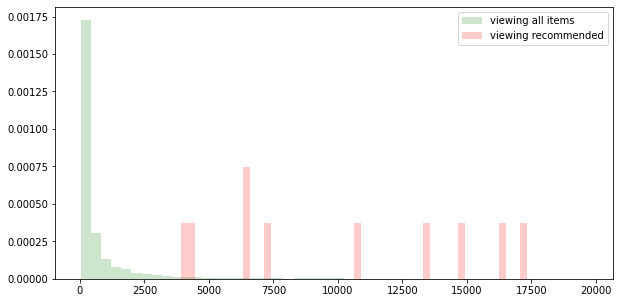

영화들의 시청이력 평균: 757.231
영화들의 시청이력 표준 편차: 1682.849
추천된 영화들의 시청이력 평균: 10100.6
추천된 영화들의 시청이력 표준 편차: 4838.099


In [59]:
# best 그룹: 전체 영화랑 추천된 영화에 대해 시청한 유저수(시청이력수) 비교.
import matplotlib.pyplot as plt

user_idx = best_users[0]

plt.figure(figsize = (10, 5))
plt.hist(all_items.view.values, color = 'green', alpha = 0.2, bins = 50, label = 'viewing all items', density = True)
plt.hist(best_reco[best_reco.user==user_idx].view.values, color = 'red', alpha = 0.2, bins = 50, label = 'viewing recommended', density = True)
plt.legend()
plt.show()

print('영화들의 시청이력 평균:', round(np.mean(all_items.view.values), 3))
print('영화들의 시청이력 표준 편차:', round(np.std(all_items.view.values), 3))

print('추천된 영화들의 시청이력 평균:', round(np.mean(best_reco[best_reco.user==user_idx].view.values), 3))
print('추천된 영화들의 시청이력 표준 편차:', round(np.std(best_reco[best_reco.user==user_idx].view.values), 3))


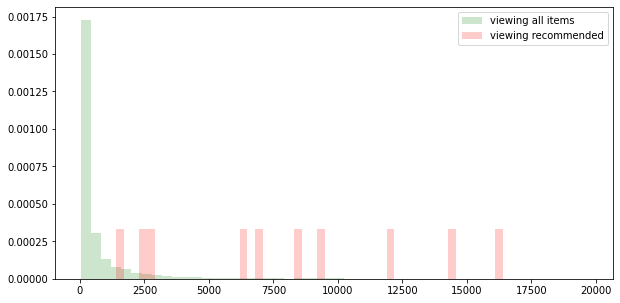

영화들의 시청이력 평균: 757.231
영화들의 시청이력 표준 편차: 1682.849
추천된 영화들의 시청이력 평균: 8045.1
추천된 영화들의 시청이력 표준 편차: 4860.893


In [60]:
# best 그룹: 전체 영화랑 추천된 영화에 대해 시청한 유저수(시청이력수) 비교.
import matplotlib.pyplot as plt

user_idx = best_users[2]

plt.figure(figsize = (10, 5))
plt.hist(all_items.view.values, color = 'green', alpha = 0.2, bins = 50, label = 'viewing all items', density = True)
plt.hist(best_reco[best_reco.user==user_idx].view.values, color = 'red', alpha = 0.2, bins = 50, label = 'viewing recommended', density = True)
plt.legend()
plt.show()

print('영화들의 시청이력 평균:', round(np.mean(all_items.view.values), 3))
print('영화들의 시청이력 표준 편차:', round(np.std(all_items.view.values), 3))

print('추천된 영화들의 시청이력 평균:', round(np.mean(best_reco[best_reco.user==user_idx].view.values), 3))
print('추천된 영화들의 시청이력 표준 편차:', round(np.std(best_reco[best_reco.user==user_idx].view.values), 3))


In [61]:
from tqdm import tqdm

mean_all = np.mean(all_items.view.values)
std_all = np.std(all_items.view.values)

cnt = 0
for i in tqdm(range(len(best_users))):
    idx = best_users[i]
    if mean_all + std_all < np.mean(best_reco[best_reco.user==idx].view.values):
        cnt += 1

print('best 그룹에 추천된 영화들이 기존 영화들의 시청횟수보다 클 확률: ', cnt*100/len(best_users),'%')

100%|██████████| 9821/9821 [00:04<00:00, 2407.44it/s]

best 그룹에 추천된 영화들이 기존 영화들의 시청횟수보다 클 확률:  99.13450768760819 %


### 가설 2: 못 맞춘 유저들은 마이너한 영화를 본다.

#### 가설2. 검증

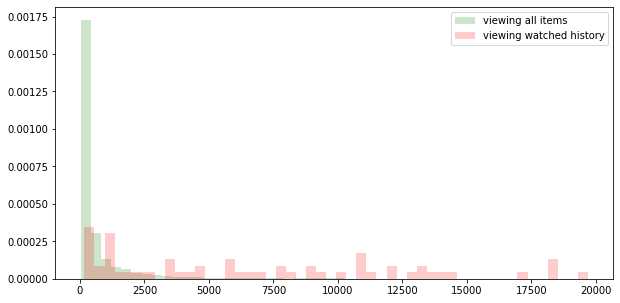

영화들의 시청이력 평균: 757.231
영화들의 시청이력 표준 편차: 1682.849
과거 시청한 영화들의 시청이력 평균: 6762.102
과거 시청한 영화들의 시청이력 표준 편차: 5683.674


In [62]:
# worst 그룹: 전체 영화랑 본 영화에 대해 시청한 유저수(시청이력수) 비교.
user_idx = lowest_users[0]

plt.figure(figsize = (10, 5))
plt.hist(all_items.view.values, color = 'green', alpha = 0.2, bins = 50, label = 'viewing all items', density = True)
plt.hist(lowest_history[lowest_history.user==user_idx].view.values, color = 'red', alpha = 0.2, bins = 50, label = 'viewing watched history', density = True)
plt.legend()
plt.show()

print('영화들의 시청이력 평균:', round(np.mean(all_items.view.values), 3))
print('영화들의 시청이력 표준 편차:', round(np.std(all_items.view.values), 3))

print('과거 시청한 영화들의 시청이력 평균:', round(np.mean(lowest_history[lowest_history.user==user_idx].view.values), 3))
print('과거 시청한 영화들의 시청이력 표준 편차:', round(np.std(lowest_history[lowest_history.user==user_idx].view.values), 3))

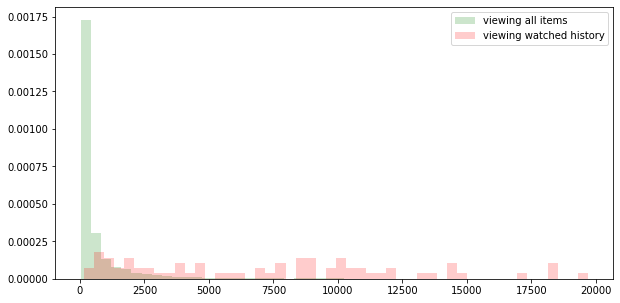

영화들의 시청이력 평균: 757.231
영화들의 시청이력 표준 편차: 1682.849
과거 시청한 영화들의 시청이력 평균: 7285.653
과거 시청한 영화들의 시청이력 표준 편차: 5194.056


In [63]:
# worst 그룹: 전체 영화랑 본 영화에 대해 시청한 유저수(시청이력수) 비교.
user_idx = lowest_users[2]

plt.figure(figsize = (10, 5))
plt.hist(all_items.view.values, color = 'green', alpha = 0.2, bins = 50, label = 'viewing all items', density = True)
plt.hist(lowest_history[lowest_history.user==user_idx].view.values, color = 'red', alpha = 0.2, bins = 50, label = 'viewing watched history', density = True)
plt.legend()
plt.show()

print('영화들의 시청이력 평균:', round(np.mean(all_items.view.values), 3))
print('영화들의 시청이력 표준 편차:', round(np.std(all_items.view.values), 3))

print('과거 시청한 영화들의 시청이력 평균:', round(np.mean(lowest_history[lowest_history.user==user_idx].view.values), 3))
print('과거 시청한 영화들의 시청이력 표준 편차:', round(np.std(lowest_history[lowest_history.user==user_idx].view.values), 3))

In [64]:
mean_all = np.mean(all_items.view.values)
std_all = np.std(all_items.view.values)

cnt = 0
for i in range(len(lowest_users)):
    idx = lowest_users[i]
    if mean_all + std_all > np.mean(lowest_history[lowest_history.user==idx].view.values):
        cnt += 1

print('worst 그룹의 본 영화들이 기존 영화들의 시청횟수보다 작을 확률: ', cnt*100/len(lowest_users),'%')

worst 그룹의 본 영화들이 기존 영화들의 시청횟수보다 작을 확률:  6.093579978237214 %


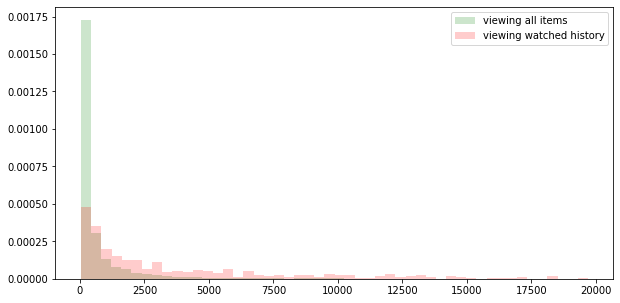

영화들의 시청이력 평균: 757.231
영화들의 시청이력 표준 편차: 1682.849
과거 시청한 영화들의 시청이력 평균: 3719.351
과거 시청한 영화들의 시청이력 표준 편차: 4310.754


In [65]:
# best 그룹: 전체 영화랑 본 영화에 대해 시청한 유저수(시청이력수) 비교.
user_idx = best_users[0]

plt.figure(figsize = (10, 5))
plt.hist(all_items.view.values, color = 'green', alpha = 0.2, bins = 50, label = 'viewing all items', density = True)
plt.hist(best_history[best_history.user==user_idx].view.values, color = 'red', alpha = 0.2, bins = 50, label = 'viewing watched history', density = True)
plt.legend()
plt.show()

print('영화들의 시청이력 평균:', round(np.mean(all_items.view.values), 3))
print('영화들의 시청이력 표준 편차:', round(np.std(all_items.view.values), 3))

print('과거 시청한 영화들의 시청이력 평균:', round(np.mean(best_history[best_history.user==user_idx].view.values), 3))
print('과거 시청한 영화들의 시청이력 표준 편차:', round(np.std(best_history[best_history.user==user_idx].view.values), 3))

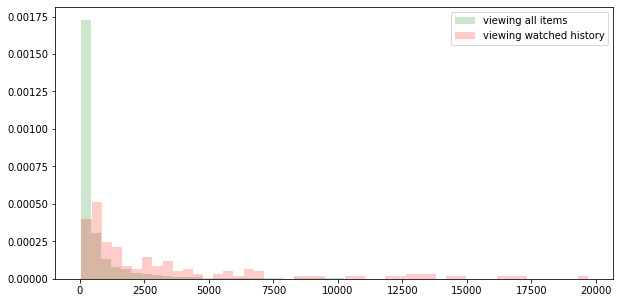

영화들의 시청이력 평균: 757.231
영화들의 시청이력 표준 편차: 1682.849
과거 시청한 영화들의 시청이력 평균: 3304.058
과거 시청한 영화들의 시청이력 표준 편차: 4193.465


In [66]:
# best 그룹: 전체 영화랑 본 영화에 대해 시청한 유저수(시청이력수) 비교.
user_idx = best_users[2]

plt.figure(figsize = (10, 5))
plt.hist(all_items.view.values, color = 'green', alpha = 0.2, bins = 50, label = 'viewing all items', density = True)
plt.hist(best_history[best_history.user==user_idx].view.values, color = 'red', alpha = 0.2, bins = 50, label = 'viewing watched history', density = True)
plt.legend()
plt.show()

print('영화들의 시청이력 평균:', round(np.mean(all_items.view.values), 3))
print('영화들의 시청이력 표준 편차:', round(np.std(all_items.view.values), 3))

print('과거 시청한 영화들의 시청이력 평균:', round(np.mean(best_history[best_history.user==user_idx].view.values), 3))
print('과거 시청한 영화들의 시청이력 표준 편차:', round(np.std(best_history[best_history.user==user_idx].view.values), 3))

In [67]:
mean_all = np.mean(all_items.view.values)
std_all = np.std(all_items.view.values)

cnt = 0
for i in range(len(best_users)):
    idx = best_users[i]
    if mean_all + std_all < np.mean(best_history[best_history.user==idx].view.values):
        cnt += 1

print('best 그룹의 본 영화들이 기존 영화들의 시청횟수보다 클 확률: ', cnt*100/len(best_users),'%')

best 그룹의 본 영화들이 기존 영화들의 시청횟수보다 클 확률:  91.18216067610223 %


### 가설 3. 못 맞춘 그룹의 추천된 영화들의 개봉년도는 보통 시청한 영화들의 범위외에 속한다.

In [68]:
years = pd.read_csv("/opt/ml/input/data/train/years.tsv", delimiter='\t')
years

,item,year
0,1348,1922
1,44587,1922
2,4768,1922
3,8235,1923
4,8609,1923
...,...,...
6794,114795,2014
6795,110771,2014
6796,112804,2014
6797,113378,2014


In [74]:
lowest_history_year = pd.merge(lowest_history, years, left_on='item', right_on='item', how='inner')
lowest_history_year

,user,item,time,view,year
0,43,261,1231445317,1014,1994
1,3963,261,1293074897,1014,1994
2,6456,261,1190087999,1014,1994
3,8158,261,1114031227,1014,1994
4,9139,261,1308405389,1014,1994
...,...,...,...,...,...
183506,138397,6082,1117047806,52,1982
183507,138397,897,1117048065,53,1943
183508,138397,6457,1117048154,61,1960
183509,138397,4473,1117048184,47,1988


In [69]:
lowest_reco_year = pd.merge(lowest_reco, years, left_on='item', right_on='item', how='inner')
lowest_reco_year

,user,item,view,year
0,43,4886,10826,2001
1,1023,4886,10826,2001
2,2405,4886,10826,2001
3,2759,4886,10826,2001
4,3254,4886,10826,2001
...,...,...,...,...
27565,138397,1590,1169,1997
27566,138397,1371,1122,1979
27567,138397,173,691,1995
27568,138397,3697,741,1990


In [70]:
best_reco_year = pd.merge(best_reco, years, left_on='item', right_on='item', how='inner')
best_reco_year

,user,item,view,year
0,11,1917,3919,1998
1,744,1917,3919,1998
2,1838,1917,3919,1998
3,6715,1917,3919,1998
4,8337,1917,3919,1998
...,...,...,...,...
98200,136599,112552,376,2014
98201,136819,8239,247,1961
98202,137447,531,966,1993
98203,137828,2485,497,1999


In [71]:
best_history_year = pd.merge(best_history, years, left_on='item', right_on='item', how='inner')
best_history_year

,user,item,time,view,year
0,11,4643,1230782529,1122,2001
1,294,4643,1288437662,1122,2001
2,609,4643,1131396199,1122,2001
3,829,4643,1337644649,1122,2001
4,951,4643,1170632154,1122,2001
...,...,...,...,...,...
2981140,120172,2036,1266567880,62,1994
2981141,120290,2036,1165171128,62,1994
2981142,122674,2036,1307274746,62,1994
2981143,128943,2036,1193334539,62,1994


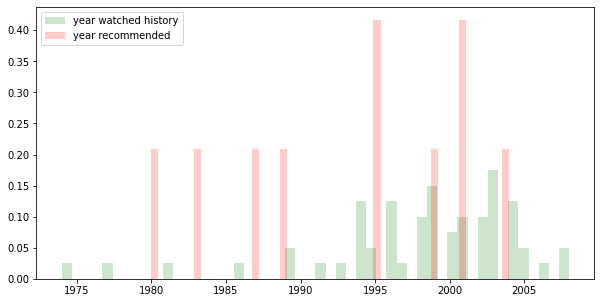

과거 시청한 영화들의 개봉년도 평균: 1998.102
과거 시청한 영화들의 개봉년도 표준 편차: 6.688
추천된 영화들의 개봉년도 평균: 1993.4
추천된 영화들의 개봉년도 표준 편차: 7.826


In [75]:
# worst 유저에게 추천된 영화와 유저가 본 영화의 개봉년도 비교
import matplotlib.pyplot as plt

user_idx = lowest_users[0]

plt.figure(figsize = (10, 5))
plt.hist(lowest_history_year[lowest_history_year.user==user_idx].year.values, color = 'green', alpha = 0.2, bins = 50, label = 'year watched history', density = True)
plt.hist(lowest_reco_year[lowest_reco_year.user==user_idx].year.values, color = 'red', alpha = 0.2, bins = 50, label = 'year recommended', density = True)
plt.legend()
plt.show()

print('과거 시청한 영화들의 개봉년도 평균:', round(np.mean(lowest_history_year[lowest_history_year.user==user_idx].year.values), 3))
print('과거 시청한 영화들의 개봉년도 표준 편차:', round(np.std(lowest_history_year[lowest_history_year.user==user_idx].year.values), 3))

print('추천된 영화들의 개봉년도 평균:', round(np.mean(lowest_reco_year[lowest_reco_year.user==user_idx].year.values), 3))
print('추천된 영화들의 개봉년도 표준 편차:', round(np.std(lowest_reco_year[lowest_reco_year.user==user_idx].year.values), 3))


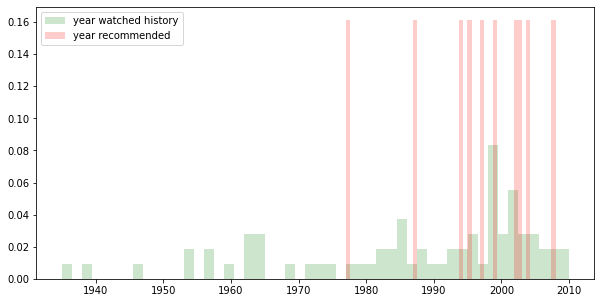

과거 시청한 영화들의 개봉년도 평균: 1986.653
과거 시청한 영화들의 개봉년도 표준 편차: 18.216
추천된 영화들의 개봉년도 평균: 1996.6
추천된 영화들의 개봉년도 표준 편차: 8.639


In [76]:
# worst 유저에게 추천된 영화와 유저가 본 영화의 개봉년도 비교
import matplotlib.pyplot as plt

user_idx = lowest_users[2]

plt.figure(figsize = (10, 5))
plt.hist(lowest_history_year[lowest_history_year.user==user_idx].year.values, color = 'green', alpha = 0.2, bins = 50, label = 'year watched history', density = True)
plt.hist(lowest_reco_year[lowest_reco_year.user==user_idx].year.values, color = 'red', alpha = 0.2, bins = 50, label = 'year recommended', density = True)
plt.legend()
plt.show()

print('과거 시청한 영화들의 개봉년도 평균:', round(np.mean(lowest_history_year[lowest_history_year.user==user_idx].year.values), 3))
print('과거 시청한 영화들의 개봉년도 표준 편차:', round(np.std(lowest_history_year[lowest_history_year.user==user_idx].year.values), 3))

print('추천된 영화들의 개봉년도 평균:', round(np.mean(lowest_reco_year[lowest_reco_year.user==user_idx].year.values), 3))
print('추천된 영화들의 개봉년도 표준 편차:', round(np.std(lowest_reco_year[lowest_reco_year.user==user_idx].year.values), 3))


In [77]:
cnt = 0
for i in range(len(lowest_users)):
    idx = lowest_users[i]
    
    mean_re = np.mean(lowest_history_year[lowest_history_year.user==idx].year.values)
    std_re = np.std(lowest_history_year[lowest_history_year.user==idx].year.values)
    tmp = np.mean(lowest_reco_year[lowest_reco_year.user==idx].year.values)

    if tmp < mean_re - std_re or tmp > mean_re+std_re:
        cnt += 1

print('worst그룹에 추천된 영화들의 개봉년도가 worst그룹이 본 영화들의 평균 개봉년도 범위 외에 있을 확률: ', cnt*100/len(lowest_users),'%')

worst그룹에 추천된 영화들의 개봉년도가 worst그룹이 본 영화들의 평균 개봉년도 범위 외에 있을 확률:  0.29017047515415306 %


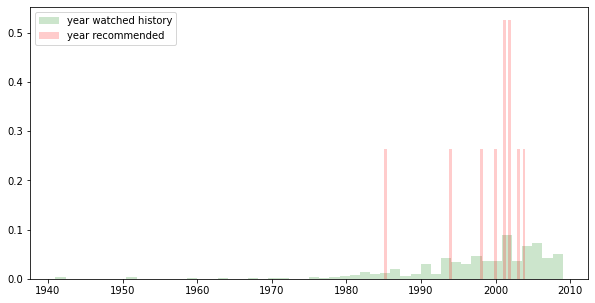

과거 시청한 영화들의 개봉년도 평균: 1997.697
과거 시청한 영화들의 개봉년도 표준 편차: 9.851
추천된 영화들의 개봉년도 평균: 1999.0
추천된 영화들의 개봉년도 표준 편차: 5.385


In [78]:
# best 유저에게 추천된 영화와 유저가 본 영화의 개봉년도 비교
import matplotlib.pyplot as plt

user_idx = best_users[0]

plt.figure(figsize = (10, 5))
plt.hist(best_history_year[best_history_year.user==user_idx].year.values, color = 'green', alpha = 0.2, bins = 50, label = 'year watched history', density = True)
plt.hist(best_reco_year[best_reco_year.user==user_idx].year.values, color = 'red', alpha = 0.2, bins = 50, label = 'year recommended', density = True)
plt.legend()
plt.show()

print('과거 시청한 영화들의 개봉년도 평균:', round(np.mean(best_history_year[best_history_year.user==user_idx].year.values), 3))
print('과거 시청한 영화들의 개봉년도 표준 편차:', round(np.std(best_history_year[best_history_year.user==user_idx].year.values), 3))

print('추천된 영화들의 개봉년도 평균:', round(np.mean(best_reco_year[best_reco_year.user==user_idx].year.values), 3))
print('추천된 영화들의 개봉년도 표준 편차:', round(np.std(best_reco_year[best_reco_year.user==user_idx].year.values), 3))


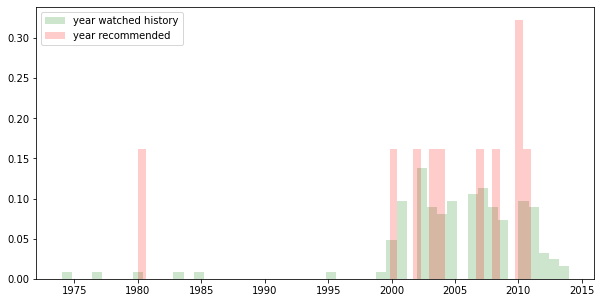

과거 시청한 영화들의 개봉년도 평균: 2005.019
과거 시청한 영화들의 개봉년도 표준 편차: 5.974
추천된 영화들의 개봉년도 평균: 2003.5
추천된 영화들의 개봉년도 표준 편차: 8.605


In [79]:
# best 유저에게 추천된 영화와 유저가 본 영화의 개봉년도 비교
import matplotlib.pyplot as plt

user_idx = best_users[2]

plt.figure(figsize = (10, 5))
plt.hist(best_history_year[best_history_year.user==user_idx].year.values, color = 'green', alpha = 0.2, bins = 50, label = 'year watched history', density = True)
plt.hist(best_reco_year[best_reco_year.user==user_idx].year.values, color = 'red', alpha = 0.2, bins = 50, label = 'year recommended', density = True)
plt.legend()
plt.show()

print('과거 시청한 영화들의 개봉년도 평균:', round(np.mean(best_history_year[best_history_year.user==user_idx].year.values), 3))
print('과거 시청한 영화들의 개봉년도 표준 편차:', round(np.std(best_history_year[best_history_year.user==user_idx].year.values), 3))

print('추천된 영화들의 개봉년도 평균:', round(np.mean(best_reco_year[best_reco_year.user==user_idx].year.values), 3))
print('추천된 영화들의 개봉년도 표준 편차:', round(np.std(best_reco_year[best_reco_year.user==user_idx].year.values), 3))


In [80]:
cnt = 0
for i in range(len(best_users)):
    idx = best_users[i]
    
    mean_re = np.mean(best_history_year[best_history_year.user==idx].year.values)
    std_re = np.std(best_history_year[best_history_year.user==idx].year.values)
    tmp = np.mean(best_reco_year[best_reco_year.user==idx].year.values)

    if mean_re - std_re <= tmp and tmp <= mean_re+std_re:
        cnt += 1

print('best그룹에 추천된 영화들의 개봉년도가 best그룹이 본 영화들의 평균 개봉년도 범위 외에 있을 확률: ', cnt*100/len(best_users),'%')

best그룹에 추천된 영화들의 개봉년도가 best그룹이 본 영화들의 평균 개봉년도 범위 외에 있을 확률:  99.96945321250382 %


### 가설 4. 못 맞춘 그룹의 추천된 영화들은 유저가 많이 보지 않은 장르의 영화들이다.

In [81]:
user_genre = pd.read_csv('user_genre.csv')
user_genre

,users,Crime,Drama,Action,Sci-Fi,Thriller,Comedy,Romance,War,Adventure,Fantasy,Horror,Mystery,Animation,Children,Film-Noir,Musical,Western,Documentary
0,11,33,112,167,176,130,99,44,12,133,67,58,25,50,53,2,11,1,5
1,14,9,66,23,23,10,106,55,5,58,34,0,6,40,57,0,22,4,0
2,18,20,62,3,2,9,28,25,9,3,3,2,7,1,1,1,2,4,1
3,25,21,41,22,8,16,40,17,5,21,14,6,5,5,9,0,2,1,0
4,31,12,24,92,49,36,49,10,5,94,47,7,9,32,44,0,0,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31355,138473,20,37,15,9,25,6,8,1,12,14,8,15,9,6,3,2,1,0
31356,138475,34,76,4,4,30,26,27,12,8,1,5,17,3,2,32,1,2,9
31357,138486,11,34,47,32,60,53,11,3,39,28,57,9,11,18,0,6,1,0
31358,138492,9,21,15,3,5,42,21,1,11,7,0,1,3,2,0,5,3,9


In [82]:
test = lowest_reco.user.unique()
lowest_user_genre = user_genre[user_genre.users.isin(test)]
lowest_user_genre.set_index('users', inplace=True)
lowest_user_genre

,Crime,Drama,Action,Sci-Fi,Thriller,Comedy,Romance,War,Adventure,Fantasy,Horror,Mystery,Animation,Children,Film-Noir,Musical,Western,Documentary
users,,,,,,,,,,,,,,,,,,
43,6,33,18,8,13,23,24,2,15,5,0,4,4,5,1,2,0,0
72,10,32,16,11,15,32,15,4,9,7,2,2,0,2,0,3,2,0
102,18,36,20,16,19,28,14,4,12,9,3,10,1,2,1,2,5,0
163,17,24,17,14,17,13,8,3,10,2,2,11,5,4,1,1,1,0
182,11,19,38,13,22,10,2,6,14,6,4,2,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138145,19,20,44,24,27,39,10,4,31,12,5,1,8,13,1,4,0,0
138246,12,69,16,19,30,39,45,6,30,32,7,13,12,16,1,7,1,0
138259,24,60,33,18,33,43,22,9,32,13,6,11,10,10,3,5,3,3


In [83]:
import warnings
warnings.filterwarnings(action='ignore') 

#유저별 많이 본 장르에 가중치를 두기: (유저의 장르별 횟수) / (유저의 전체 장르 횟수)
lowest_user_genre['total'] = lowest_user_genre.sum(axis=1).values
lowest_users_genre_prefer = lowest_user_genre.iloc[:,0:].div(lowest_user_genre.total, axis=0)
lowest_users_genre_prefer.drop('total', axis=1, inplace=True)
lowest_users_genre_prefer

,Crime,Drama,Action,Sci-Fi,Thriller,Comedy,Romance,War,Adventure,Fantasy,Horror,Mystery,Animation,Children,Film-Noir,Musical,Western,Documentary
users,,,,,,,,,,,,,,,,,,
43,0.036810,0.202454,0.110429,0.049080,0.079755,0.141104,0.147239,0.012270,0.092025,0.030675,0.000000,0.024540,0.024540,0.030675,0.006135,0.012270,0.000000,0.000000
72,0.061728,0.197531,0.098765,0.067901,0.092593,0.197531,0.092593,0.024691,0.055556,0.043210,0.012346,0.012346,0.000000,0.012346,0.000000,0.018519,0.012346,0.000000
102,0.090000,0.180000,0.100000,0.080000,0.095000,0.140000,0.070000,0.020000,0.060000,0.045000,0.015000,0.050000,0.005000,0.010000,0.005000,0.010000,0.025000,0.000000
163,0.113333,0.160000,0.113333,0.093333,0.113333,0.086667,0.053333,0.020000,0.066667,0.013333,0.013333,0.073333,0.033333,0.026667,0.006667,0.006667,0.006667,0.000000
182,0.073333,0.126667,0.253333,0.086667,0.146667,0.066667,0.013333,0.040000,0.093333,0.040000,0.026667,0.013333,0.006667,0.000000,0.006667,0.000000,0.006667,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138145,0.072519,0.076336,0.167939,0.091603,0.103053,0.148855,0.038168,0.015267,0.118321,0.045802,0.019084,0.003817,0.030534,0.049618,0.003817,0.015267,0.000000,0.000000
138246,0.033803,0.194366,0.045070,0.053521,0.084507,0.109859,0.126761,0.016901,0.084507,0.090141,0.019718,0.036620,0.033803,0.045070,0.002817,0.019718,0.002817,0.000000
138259,0.071006,0.177515,0.097633,0.053254,0.097633,0.127219,0.065089,0.026627,0.094675,0.038462,0.017751,0.032544,0.029586,0.029586,0.008876,0.014793,0.008876,0.008876


In [84]:
gen = pd.read_csv("/opt/ml/input/data/train/genres.tsv", delimiter='\t')
gen

,item,genre
0,318,Crime
1,318,Drama
2,2571,Action
3,2571,Sci-Fi
4,2571,Thriller
...,...,...
15928,109850,Drama
15929,8605,Action
15930,8605,Comedy
15931,3689,Comedy


In [85]:
from tqdm import tqdm

lowest_reco_year['genre_interest'] = 0.0
for i in tqdm(range(len(lowest_reco_year))):
    u = lowest_reco_year['user'][i]
    its = lowest_reco_year['item'][i]
    
    tmp_gen = gen[gen.item == its].genre.values

    interest = 0
    for x in tmp_gen:
        interest += lowest_users_genre_prefer.loc[u][x]

    lowest_reco_year['genre_interest'][i] = interest/len(tmp_gen)

100%|██████████| 27570/27570 [02:52<00:00, 159.81it/s]


In [86]:
lowest_reco_year

,user,item,view,year,genre_interest
0,43,4886,10826,2001,0.063804
1,1023,4886,10826,2001,0.095556
2,2405,4886,10826,2001,0.084000
3,2759,4886,10826,2001,0.097590
4,3254,4886,10826,2001,0.102158
...,...,...,...,...,...
27565,138397,1590,1169,1997,0.135572
27566,138397,1371,1122,1979,0.169776
27567,138397,173,691,1995,0.144279
27568,138397,3697,741,1990,0.179104


In [87]:
best_user_genre = user_genre[user_genre.users.isin(best_users)]
best_user_genre.set_index('users', inplace=True)

best_user_genre['total'] = best_user_genre.sum(axis=1).values
best_users_genre_prefer = best_user_genre.iloc[:,0:].div(best_user_genre.total, axis=0)
best_users_genre_prefer.drop('total', axis=1, inplace=True)
best_users_genre_prefer

,Crime,Drama,Action,Sci-Fi,Thriller,Comedy,Romance,War,Adventure,Fantasy,Horror,Mystery,Animation,Children,Film-Noir,Musical,Western,Documentary
users,,,,,,,,,,,,,,,,,,
11,0.028014,0.095076,0.141766,0.149406,0.110357,0.084041,0.037351,0.010187,0.112903,0.056876,0.049236,0.021222,0.042445,0.044992,0.001698,0.009338,0.000849,0.004244
14,0.017375,0.127413,0.044402,0.044402,0.019305,0.204633,0.106178,0.009653,0.111969,0.065637,0.000000,0.011583,0.077220,0.110039,0.000000,0.042471,0.007722,0.000000
31,0.023166,0.046332,0.177606,0.094595,0.069498,0.094595,0.019305,0.009653,0.181467,0.090734,0.013514,0.017375,0.061776,0.084942,0.000000,0.000000,0.011583,0.003861
96,0.084223,0.150652,0.119810,0.068802,0.092527,0.112693,0.042705,0.014235,0.104389,0.047450,0.009490,0.040332,0.041518,0.041518,0.004745,0.011862,0.011862,0.001186
116,0.096118,0.155268,0.157116,0.060998,0.118299,0.127542,0.027726,0.040665,0.081331,0.024030,0.033272,0.033272,0.012939,0.014787,0.003697,0.003697,0.005545,0.003697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138419,0.093484,0.198300,0.103399,0.052408,0.104816,0.110482,0.058074,0.024079,0.079320,0.039660,0.021246,0.036827,0.025496,0.022663,0.004249,0.014164,0.007082,0.004249
138429,0.084302,0.104651,0.162791,0.087209,0.127907,0.095930,0.014535,0.026163,0.122093,0.058140,0.046512,0.034884,0.014535,0.011628,0.005814,0.002907,0.000000,0.000000
138437,0.069444,0.159392,0.103175,0.083333,0.095899,0.140212,0.050926,0.019841,0.075397,0.043651,0.031746,0.033730,0.030423,0.018519,0.005952,0.013228,0.007275,0.017857


In [88]:
from tqdm import tqdm

best_reco_year['genre_interest'] = 0.0
for i in tqdm(range(len(best_reco_year))):
    u = best_reco_year['user'][i]
    its = best_reco_year['item'][i]
    
    tmp_gen = gen[gen.item == its].genre.values

    interest = 0
    for x in tmp_gen:
        interest += best_users_genre_prefer.loc[u][x]

    best_reco_year['genre_interest'][i] = interest/len(tmp_gen)

100%|██████████| 98205/98205 [10:14<00:00, 159.83it/s]


In [89]:
best_reco_year

,user,item,view,year,genre_interest
0,11,1917,3919,1998,0.109720
1,744,1917,3919,1998,0.097706
2,1838,1917,3919,1998,0.129219
3,6715,1917,3919,1998,0.099181
4,8337,1917,3919,1998,0.091176
...,...,...,...,...,...
98200,136599,112552,376,2014,0.259048
98201,136819,8239,247,1961,0.220272
98202,137447,531,966,1993,0.151466
98203,137828,2485,497,1999,0.246493


In [90]:
print(np.mean(lowest_reco_year.genre_interest))
print(np.mean(best_reco_year.genre_interest))

0.11572637157168689
0.11135126412309325


In [91]:
print(len(lowest_reco_year[lowest_reco_year.genre_interest < 1/18]) / len(lowest_reco_year))
print(len(best_reco_year[best_reco_year.genre_interest < 1/18]) / len(best_reco_year))


0.06401886108088502
0.046229825365307266


### 가설5: 못 맞춘 유저에게 추천된 영화의 평균 시청 이력은 해당 유저가 본 영화들의 평균 시청이력보다 낮다.

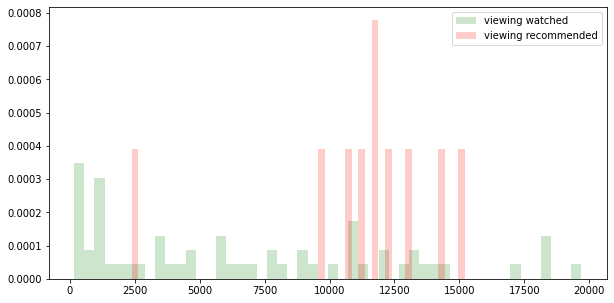

본 영화들의 시청이력 평균: 6762.102
본 영화들의 시청이력 표준 편차: 5683.674
추천된 영화들의 시청이력 평균: 11265.4
추천된 영화들의 시청이력 표준 편차: 3342.542


In [92]:
# worst 그룹: 본 영화랑 추천된 영화에 대해 시청한 유저수(시청이력수) 비교.
import matplotlib.pyplot as plt

user_idx = lowest_users[0]

plt.figure(figsize = (10, 5))
plt.hist(lowest_history[lowest_history.user==user_idx].view.values, color = 'green', alpha = 0.2, bins = 50, label = 'viewing watched', density = True)
plt.hist(lowest_reco[lowest_reco.user==user_idx].view.values, color = 'red', alpha = 0.2, bins = 50, label = 'viewing recommended', density = True)
plt.legend()
plt.show()

print('본 영화들의 시청이력 평균:', round(np.mean(lowest_history[lowest_history.user==user_idx].view.values), 3))
print('본 영화들의 시청이력 표준 편차:', round(np.std(lowest_history[lowest_history.user==user_idx].view.values), 3))

print('추천된 영화들의 시청이력 평균:', round(np.mean(lowest_reco[lowest_reco.user==user_idx].view.values), 3))
print('추천된 영화들의 시청이력 표준 편차:', round(np.std(lowest_reco[lowest_reco.user==user_idx].view.values), 3))


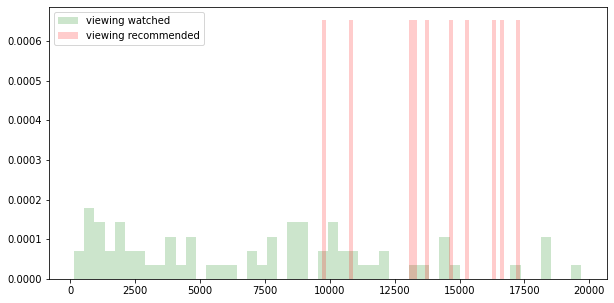

본 영화들의 시청이력 평균: 7285.653
본 영화들의 시청이력 표준 편차: 5194.056
추천된 영화들의 시청이력 평균: 14089.8
추천된 영화들의 시청이력 표준 편차: 2356.918


In [93]:
# worst 그룹: 본 영화랑 추천된 영화에 대해 시청한 유저수(시청이력수) 비교.
import matplotlib.pyplot as plt

user_idx = lowest_users[2]

plt.figure(figsize = (10, 5))
plt.hist(lowest_history[lowest_history.user==user_idx].view.values, color = 'green', alpha = 0.2, bins = 50, label = 'viewing watched', density = True)
plt.hist(lowest_reco[lowest_reco.user==user_idx].view.values, color = 'red', alpha = 0.2, bins = 50, label = 'viewing recommended', density = True)
plt.legend()
plt.show()

print('본 영화들의 시청이력 평균:', round(np.mean(lowest_history[lowest_history.user==user_idx].view.values), 3))
print('본 영화들의 시청이력 표준 편차:', round(np.std(lowest_history[lowest_history.user==user_idx].view.values), 3))

print('추천된 영화들의 시청이력 평균:', round(np.mean(lowest_reco[lowest_reco.user==user_idx].view.values), 3))
print('추천된 영화들의 시청이력 표준 편차:', round(np.std(lowest_reco[lowest_reco.user==user_idx].view.values), 3))


In [94]:
cnt = 0
for i in tqdm(range(len(lowest_users))):
    idx = lowest_users[i]

    mean_re = np.mean(lowest_history[lowest_history.user==idx].view.values)
    std_re = np.std(lowest_history[lowest_history.user==idx].view.values)
    tmp = np.mean(lowest_reco[lowest_reco.user==idx].view.values)

    if tmp < mean_re-std_re or mean_re+std_re < tmp:
        cnt += 1

print('worst 그룹에 추천된 영화들이 본 영화들의 시청횟수 범위 외에 있을 확률: ', cnt*100/len(lowest_users),'%')

100%|██████████| 2757/2757 [00:03<00:00, 763.83it/s]

worst 그룹에 추천된 영화들이 본 영화들의 시청횟수 범위 외에 있을 확률:  46.354733405875955 %


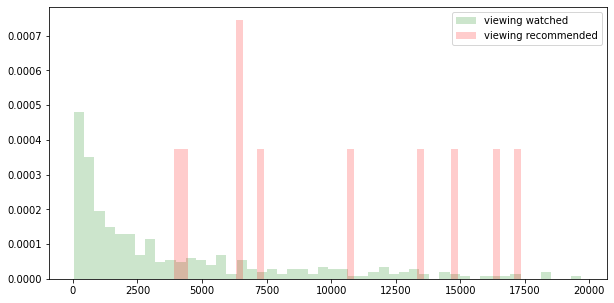

본 영화들의 시청이력 평균: 3719.351
본 영화들의 시청이력 표준 편차: 4310.754
추천된 영화들의 시청이력 평균: 10100.6
추천된 영화들의 시청이력 표준 편차: 4838.099


In [95]:
# best 그룹: 본 영화랑 추천된 영화에 대해 시청한 유저수(시청이력수) 비교.
import matplotlib.pyplot as plt

user_idx = best_users[0]

plt.figure(figsize = (10, 5))
plt.hist(best_history[best_history.user==user_idx].view.values, color = 'green', alpha = 0.2, bins = 50, label = 'viewing watched', density = True)
plt.hist(best_reco[best_reco.user==user_idx].view.values, color = 'red', alpha = 0.2, bins = 50, label = 'viewing recommended', density = True)
plt.legend()
plt.show()

print('본 영화들의 시청이력 평균:', round(np.mean(best_history[best_history.user==user_idx].view.values), 3))
print('본 영화들의 시청이력 표준 편차:', round(np.std(best_history[best_history.user==user_idx].view.values), 3))

print('추천된 영화들의 시청이력 평균:', round(np.mean(best_reco[best_reco.user==user_idx].view.values), 3))
print('추천된 영화들의 시청이력 표준 편차:', round(np.std(best_reco[best_reco.user==user_idx].view.values), 3))


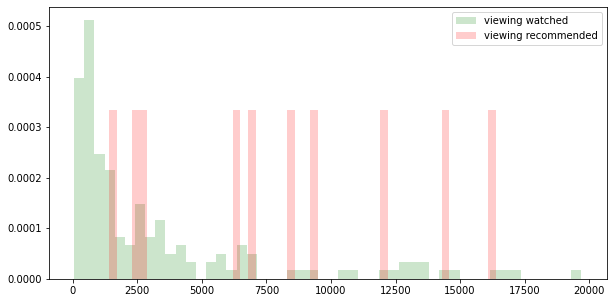

본 영화들의 시청이력 평균: 3304.058
본 영화들의 시청이력 표준 편차: 4193.465
추천된 영화들의 시청이력 평균: 8045.1
추천된 영화들의 시청이력 표준 편차: 4860.893


In [96]:
# best 그룹: 본 영화랑 추천된 영화에 대해 시청한 유저수(시청이력수) 비교.
import matplotlib.pyplot as plt

user_idx = best_users[2]

plt.figure(figsize = (10, 5))
plt.hist(best_history[best_history.user==user_idx].view.values, color = 'green', alpha = 0.2, bins = 50, label = 'viewing watched', density = True)
plt.hist(best_reco[best_reco.user==user_idx].view.values, color = 'red', alpha = 0.2, bins = 50, label = 'viewing recommended', density = True)
plt.legend()
plt.show()

print('본 영화들의 시청이력 평균:', round(np.mean(best_history[best_history.user==user_idx].view.values), 3))
print('본 영화들의 시청이력 표준 편차:', round(np.std(best_history[best_history.user==user_idx].view.values), 3))

print('추천된 영화들의 시청이력 평균:', round(np.mean(best_reco[best_reco.user==user_idx].view.values), 3))
print('추천된 영화들의 시청이력 표준 편차:', round(np.std(best_reco[best_reco.user==user_idx].view.values), 3))


In [97]:
cnt = 0
for i in tqdm(range(len(best_users))):
    idx = best_users[i]

    mean_re = np.mean(best_history[best_history.user==idx].view.values)
    std_re = np.std(best_history[best_history.user==idx].view.values)
    tmp = np.mean(best_reco[best_reco.user==idx].view.values)

    if mean_re-std_re <= tmp and tmp <= mean_re+std_re:
        cnt += 1

print('best 그룹에 추천된 영화들이 본 영화들의 시청횟수 범위 내에 있을 확률: ', cnt*100/len(best_users),'%')

100%|██████████| 9821/9821 [01:15<00:00, 130.41it/s]

best 그룹에 추천된 영화들이 본 영화들의 시청횟수 범위 내에 있을 확률:  44.832501781895935 %
